# HW4_1 - LDA and graph methods

Learning contents:

* FDA (2 classes)
    * Compute the class means (in PCA space)
    * Compute the within-class scatter matrix $\mathbf{S}_W$ and between-class scatter matrix $\mathbf{S}_B$
    * Compute the projection vector $\mathbf{w}$
    * Compute and plot the 1D projection of the data
    * Compute the class separation of the projected values
* LDA (3 classes)
    * Compute the within-class scatter matrix $\mathbf{S}_W$ and between-class scatter matrix $\mathbf{S}_B$
    * Compute the projection matrix $\mathbf{W}$
    * Compute and plot the 2D projection of the data
    * Compute the 2D LDA projection of the original 64D data 
* Extra: Laplacian Embedding
    * Create the 2D Laplacian Embedding of the swiss-roll dataset

In [1]:
# Dependencies
import numpy as np
import scipy
from sklearn.datasets import load_digits, make_swiss_roll
from sklearn.decomposition import PCA 
import matplotlib.pyplot as plt 
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns; sns.set(); sns.set_palette('bright')
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.neighbors import kneighbors_graph
from scipy.sparse.csgraph import laplacian

## Data
As usual, we'll be working with a dataset of handwritten digits. 
Let visualise some examples.

In [2]:
# We're using a subset of two classes for now
digits = load_digits(n_class=2)

In [3]:
# Handy plotting functions

def plot_examples():
    show_num = 4
    _, axes = plt.subplots(1, show_num)
    images_and_labels = list(zip(digits.images, digits.target))
    for ax, (image, label) in zip(axes[:], images_and_labels[:show_num]):
        ax.set_axis_off()
        ax.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
        ax.set_title('Label: %i' % label)

def plot_scatter(data, target, alpha=0.5, legend=True):
    scatter = plt.scatter(data[:, 0], data[:, 1], c=target, edgecolor='none', alpha=alpha, cmap='rainbow')
    if legend:
        plt.legend(*scatter.legend_elements(), loc="upper right", title="Targets")
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    
def plot_scatter3d(data, targets, view_point=(25, 45), alpha=0.5, legend=True):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(data[:,0], data[:,1], data[:,2], c=targets, cmap="rainbow", alpha=alpha)
    if legend:
        plt.legend(*scatter.legend_elements(), loc="upper right", title="Targets")
    ax.view_init(*view_point) # <- change viewpoint here
    ax.set_xlabel('Component 1')
    ax.set_ylabel('Component 2')
    ax.set_zlabel('Component 3')
    plt.show()

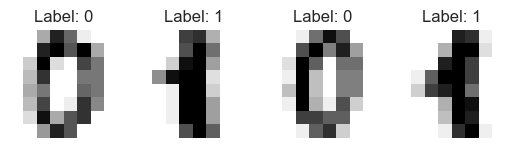

In [4]:
plot_examples()

In [5]:
# We can get a 2D version of the data using PCA
pca = PCA(n_components=2)
X = pca.fit_transform(digits.data) # this is the representation, we'll be working with
t = digits.target

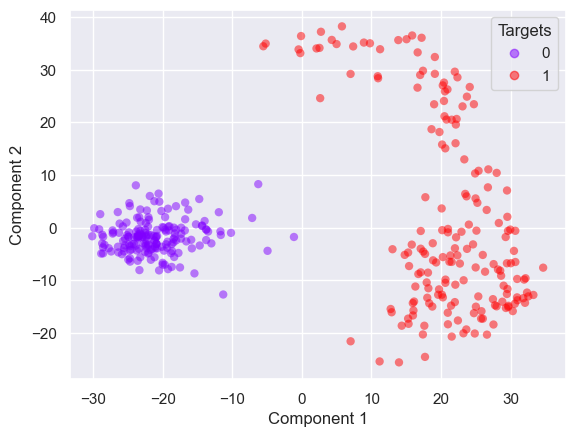

In [6]:
# Let's plot all the data in 2D
plot_scatter(X, t)

## 1) Fisher Discriminant Analysis (FDA)


### 1.1) Compute the class means (in PCA space)

In [7]:
mean_class_1 = np.mean(X[t == 0], axis=0)
mean_class_2 = np.mean(X[t == 1], axis=0)

### 1.2) Compute the within-class scatter matrix $\mathbf{S}_W$ and between-class scatter matrix $\mathbf{S}_B$

In [8]:
X1 = X[t == 0]
X2 = X[t == 1]

# Within-class scatter matrix Sw
Sw = np.zeros((2,2))
for i in range(X1.shape[0]):
    row, mv = X1[i].reshape(2,1), mean_class_1.reshape(2,1)
    Sw += (row-mv).dot((row-mv).T)
for i in range(X2.shape[0]):
    row, mv = X2[i].reshape(2,1), mean_class_2.reshape(2,1)
    Sw += (row-mv).dot((row-mv).T)
    
# Between-class scatter matrix Sb
mean_diff = mean_class_1 - mean_class_2
Sb = np.outer(mean_diff, mean_diff)

### 1.3) Compute the projection vector $\mathbf{w}$
Hint: You can use `np.linalg.pinv` and `np.linalg.eig` for computing the pseudo-inverse and eigenvectors, respectively.
Also, remember to ensure that $||w||_2 = 1$

In [9]:
eigvals, eigvecs = np.linalg.eig(np.linalg.pinv(Sw).dot(Sb))
eiglist = [(eigvals[i], eigvecs[:,i]) for i in range(len(eigvals))]
eiglist = sorted(eiglist, key = lambda x : x[0], reverse = True)
w = eiglist[0][1]
if w[1] < 0: # we want the direction to point from class 1 to class 2
    w = -w

### 1.4) Compute and plot the 1D projection of the data
Hint: You can use `seaborn.displot` for a nice visualisation

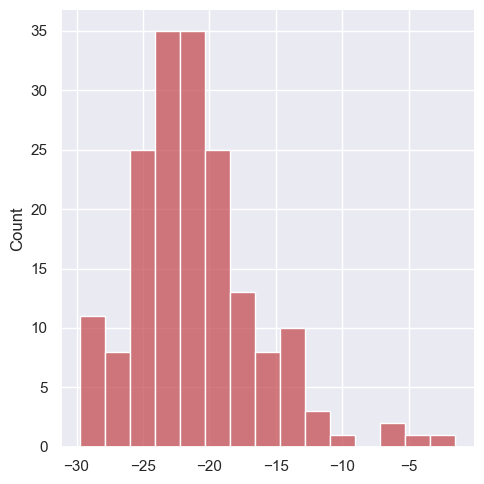

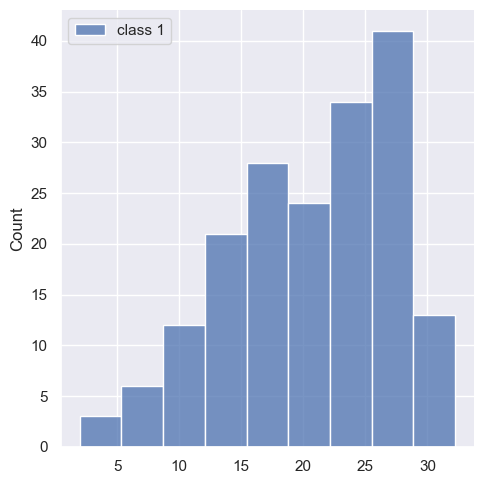

In [10]:
X_lda = X.dot(w)
sns.displot(X_lda[t==0], color='r', label='class 0')
sns.displot(X_lda[t==1], color='b', label='class 1')
plt.legend()
plt.show()

### 1.5) Compute the class separation of the projected values

In [11]:
separation = abs(np.mean(X_lda[t==1]) - np.mean(X_lda[t==0]))
print("Class separation: ", separation)

Class separation:  41.5963134998038


## 2) Linear Discriminant Analysis (LDA)

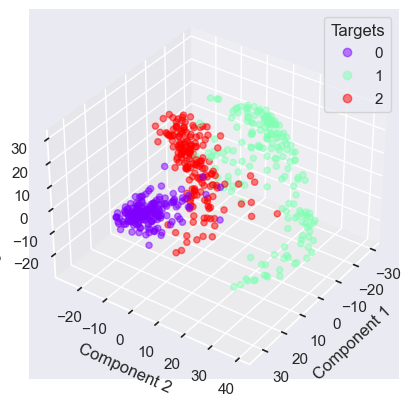

In [12]:
# Data
n_class = 3
digits = load_digits(n_class=n_class)
pca = PCA(n_components=3)
X = pca.fit_transform(digits.data)
t = digits.target

plot_scatter3d(X, t, view_point=(35,35))

### 2.1) Compute the within-class scatter matrix $\mathbf{S}_W$ and between-class scatter matrix $\mathbf{S}_B$

In [13]:
means = []
Sw = np.zeros((3, 3))
Sb = np.zeros((3, 3))
overall_mean = np.mean(X, axis=0)

for i in range(n_class):
    class_samples = X[t == i]
    class_mean = np.mean(class_samples, axis=0)
    means.append(class_mean)
    Sw += (class_samples - class_mean).T @ (class_samples - class_mean)
    Sb += class_samples.shape[0] * ((class_mean - overall_mean).reshape(3,1) @ (class_mean - overall_mean).reshape(1,3))

### 2.2) Compute the projection matrix $\mathbf{W}$

In [14]:
eigvals, eigvecs = np.linalg.eig(np.linalg.inv(Sw) @ Sb)
eiglist = [(eigvals[i], eigvecs[:,i]) for i in range(len(eigvals))]
eiglist = sorted(eiglist, key = lambda x : x[0], reverse = True)
W = np.hstack([eiglist[i][1].reshape(3,1) for i in range(2)])

### 2.3) Compute and plot the 2D projection of the data

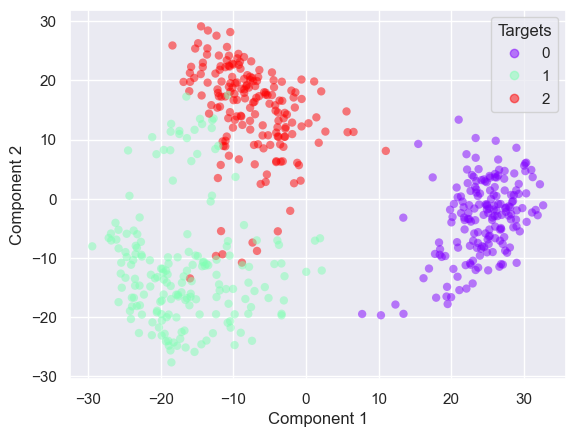

In [15]:
X_lda = X @ W
plot_scatter(X_lda, t)

### 2.4) Compute and plot the 2D LDA projection of the original 64D data 

In [16]:
# Data
n_class = 3
digits = load_digits(n_class=n_class)
X = digits.data
t = digits.target

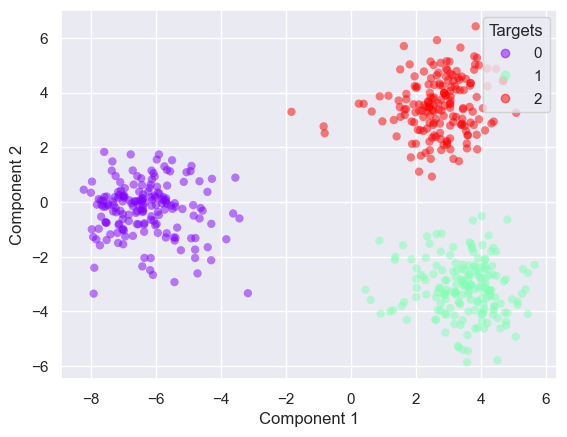

In [17]:
lda = LDA(n_components=2)
X_lda_64 = lda.fit_transform(digits.data, digits.target)
plot_scatter(X_lda_64, t)

Comment on the general utility of the projection as compared to PCA

### -> LDA: find the projection that maximizes the class separability while minimizing the within-class scatter | more suitable when the class separability is important and the goal is to optimize classification performance. 
### ->PCA: exploring the overall structure and patterns in the data, identifying dominant features, and reducing the dimensionality for computational efficiency | more appropriate if the goal is to capture the overall structure and patterns in the data, or when there is no clear separation between classes.


## 3) Extra: Laplacian Embedding
We'll be working with the swiss-roll dataset

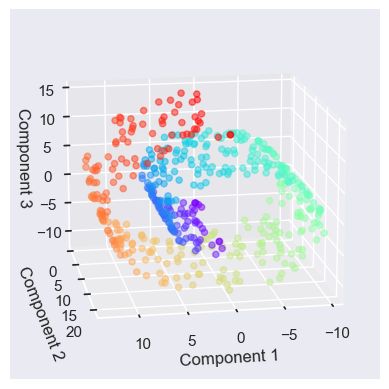

In [24]:
X, t = make_swiss_roll(500)
plot_scatter3d(X, t, view_point=(15,80), legend=False)

### 3.1) Create the 2D Laplacian Embedding of the dataset
Play with the sigma of the Gaussian kernel (start around $\sigma = 1.5$) to get a nice "boomerang"-looking shape

Hint: Omit the eigenvector corresponding to the largest eigenvalue

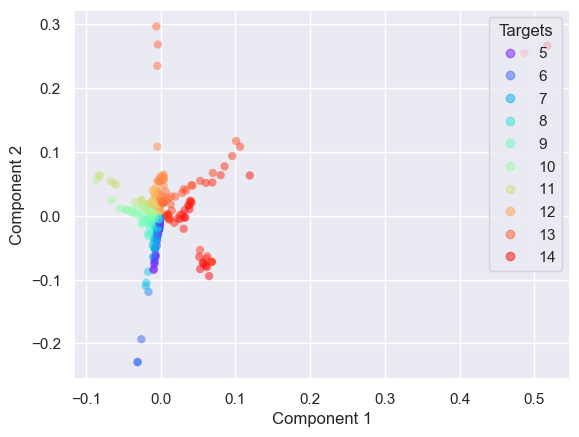

In [25]:
# Compute RBF kernel (similarity matrix)
sigma = 1.5
gamma = 1.0 / (2 * sigma**2)
similarity_matrix = rbf_kernel(X, gamma=gamma)

# Compute adjacency matrix using k-nearest neighbors
n_neighbors = 8
A = kneighbors_graph(X, n_neighbors=n_neighbors, mode='connectivity')

# Compute Laplacian matrix
L = laplacian(A, normed=True)

# Compute eigenvalues and eigenvectors of the Laplacian
eigvals, eigvecs = np.linalg.eig(L.toarray())

# Sort the eigenvalues (and corresponding eigenvectors) in ascending order
index = np.argsort(eigvals)
eigvals = eigvals[index]
eigvecs = eigvecs[:, index]

# Omit the first eigenvector (corresponding to the smallest eigenvalue)
X_laplacian = np.real(eigvecs[:, 1:3])

# Plot the 2D Laplacian Embedding
plot_scatter(X_laplacian, t)